In [ ]:
%pip install ipykernel==6.29.4
%pip install python-dotenv==1.0.1
%pip install simclr==1.0.2
%pip install roboflow==1.1.27

In [1]:
# Download dataset

from roboflow import Roboflow
from dotenv import load_dotenv
import os
load_dotenv()

rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace("yaid-pzikt").project("firefighting-device-detection")
version = project.version(6)
dataset = version.download("yolov8")
dataset.__dict__

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.


{'name': 'Firefighting Device Detection',
 'version': '6',
 'model_format': 'yolov8',
 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}

In [2]:
# Load dataset info

import os
import yaml

data_dir = './Firefighting-Device-Detection-6'
imagenet_int_to_str = {}

with open(os.path.join(data_dir, 'data.yaml'), 'r') as f:
  data = yaml.safe_load(f)

labels = data.get('names', [])
num_classes = data.get('nc', [])
assert len(labels) == num_classes
labels, num_classes

(['24V-power-cord',
  'acousto-optic-alarm',
  'area-display',
  'bus-isolation-module',
  'coded-smoke-detector',
  'coded-temperature-detector',
  'dedicated-metal-module-box-for-fire-pump',
  'dedicated-metal-module-box-for-fire-smoke-exhaust-fan',
  'dedicated-metal-module-box-for-fire-supplementary-fan',
  'deflation-indicator-light',
  'electrical-fire-monitoring-line',
  'emergency-manual-start-stop-button',
  'explosion-proof-smoke-detector',
  'fire-broadcasting-line',
  'fire-equipment-power-monitoring-line',
  'fire-fan-manual-control-line',
  'fire-hydrant-button',
  'fire-telephone-extension',
  'fire-water-pump-manual-control-line',
  'gas-spray-audible-and-visual-alarm',
  'gun-type-infrared-camera-in-the-basement',
  'i-o-module',
  'input-module',
  'light-display',
  'manual-alarm-button-with-fire-telephone-jack',
  'manual-automatic-switching-device',
  'metal-modular-box',
  'normally-open-smoke-exhaust-valve-with-280-operation',
  'normally-open-smoke-exhaust-valve

In [3]:
# Download model

model_path = "checkpoint_100.tar"
!wget https://github.com/Spijkervet/SimCLR/releases/download/1.2/$model_path

In [4]:
# Config: https://github.com/Spijkervet/SimCLR/blob/master/config/config.yaml

config = {
    "image_size": 224,
    "workers": 8,
    "resnet": "resnet50",
    "projection_dim": 64,
    "max_boxes": 50,
    "trials": 5,
    "epochs": 5,
    "batch_size": [2, 8], # range to sample from
    "lr": [1e-7, 1e-4],
    "weight_decay": [1e-6, 1e-4],
}

In [5]:
# Fixed SimCLR transforms: https://github.com/Spijkervet/SimCLR/blob/master/simclr/modules/transformations/simclr.py

import torchvision


class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, size):
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(size=(size, size)),  # Single int didn't work
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

In [6]:
# Dataloader

import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class DetectionDataset(Dataset):
    def __init__(self, split):
        path = os.path.join(data_dir, split)
        images_dir = os.path.join(path, "images")
        labels_dir = os.path.join(path, "labels")
        self.image_paths = glob.glob(os.path.join(images_dir, "*.jpg"))
        self.label_paths = glob.glob(os.path.join(labels_dir, "*.txt"))

        transform = TransformsSimCLR(size=config["image_size"])
        if split == "train":
            self.apply_transform = transform.train_transform
        else:
            self.apply_transform = transform.test_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(img_path).convert("RGB")
        image = self.apply_transform(image)

        annotations = []
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_min, y_min, x_max, y_max = map(float, line.strip().split())
                annotations.append((int(class_id), x_min, y_min, x_max, y_max))

        # Pad if necessary
        if len(annotations) > config["max_boxes"]:
            annotations = annotations[:config["max_boxes"]]
        elif len(annotations) < config["max_boxes"]:
            annotations += [(0, 0, 0, 0, 0)] * (config["max_boxes"] - len(annotations))

        class_ids = torch.tensor([a[0] for a in annotations], dtype=torch.long)
        boxes = torch.tensor([a[1:] for a in annotations], dtype=torch.float32)
        
        return image, class_ids, boxes
    

def collate_fn(batch):
    images, class_ids, boxes = zip(*batch)
    images = torch.stack(images)
    class_ids = torch.stack(class_ids)
    boxes = torch.stack(boxes)
    return images, (class_ids, boxes)


train_dataset = DetectionDataset(split="train")
valid_dataset = DetectionDataset(split="valid")
test_dataset = DetectionDataset(split="test")

In [7]:
# Object detection model

import torch.nn as nn
from simclr import SimCLR
from simclr.modules import get_resnet


class DetectionModel(nn.Module):
    def __init__(self, simclr_model):
        super(DetectionModel, self).__init__()
        self.feature_extractor = simclr_model.encoder
        self.bbox_regressor = nn.Linear(simclr_model.n_features, config["max_boxes"] * 4)
        self.classifier = nn.Linear(simclr_model.n_features, config["max_boxes"] * (num_classes + 1))  # +1 for background

    def forward(self, img):
        features = self.feature_extractor(img)
        class_logits = self.classifier(features).view(-1, config["max_boxes"], num_classes + 1)
        bboxes = self.bbox_regressor(features).view(-1, config["max_boxes"], 4)
        return class_logits, bboxes

In [8]:
# Loss function

def detection_loss(pred_classes, pred_boxes, true_labels, true_boxes):    
    flat_pred_classes = pred_classes.view(-1, pred_classes.size(-1))  # Flatten to [batch_size * max_boxes, num_classes]
    flat_true_labels = true_labels.view(-1)  # Flatten to [batch_size * max_boxes]
    
    valid_mask = true_labels > 0

    valid_indices = valid_mask.view(-1)
    class_loss = nn.CrossEntropyLoss()(flat_pred_classes[valid_indices], flat_true_labels[valid_indices])
    
    valid_boxes = valid_mask.unsqueeze(-1).expand_as(true_boxes) 
    loc_loss = nn.SmoothL1Loss()(pred_boxes[valid_boxes], true_boxes[valid_boxes])

    return class_loss + loc_loss

In [9]:
# Validation function

def validate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    for images, (class_labels, bbox) in dataloader:
        images = images.to(device)
        class_labels = class_labels.to(device)
        bbox = bbox.to(device)
        with torch.no_grad():
            predicted_classes, predicted_bboxes = model(images)
            loss = detection_loss(predicted_classes, predicted_bboxes, class_labels, bbox )
            total_loss += loss.item()
    return total_loss / len(dataloader)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


Trial 1/5
Batch size: 5, Learning rate: 2.6128099924596712e-05, Weight decay: 1.4513397027689096e-06
Epoch 1, Train Loss: 3.9010228753089904
Epoch 1, Validation Loss: 3.723927116394043
Epoch 2, Train Loss: 3.2530606508255007
Epoch 2, Validation Loss: 3.0892295360565187
Epoch 3, Train Loss: 2.639350187778473
Epoch 3, Validation Loss: 2.900147485733032
Epoch 4, Train Loss: 2.394388550519943
Epoch 4, Validation Loss: 2.943129825592041
Epoch 5, Train Loss: 2.337804597616196
Epoch 5, Validation Loss: 2.902084732055664
Test Loss: 3.005666891733805


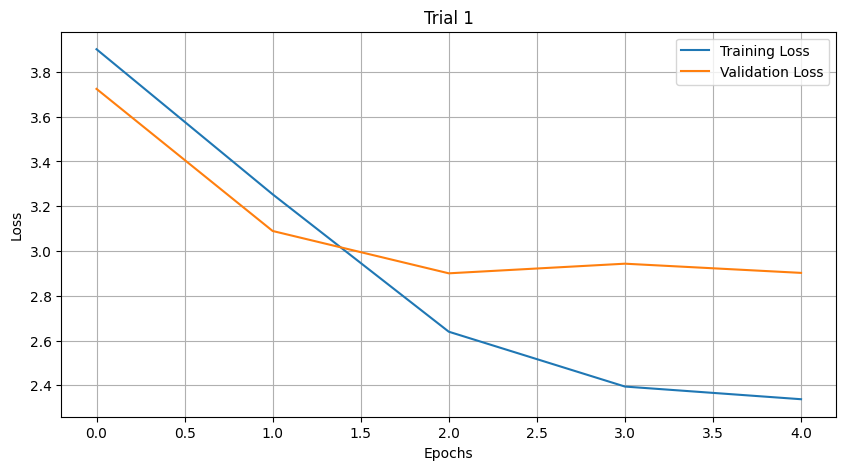

Trial 2/5
Batch size: 2, Learning rate: 8.474840586866013e-07, Weight decay: 7.538320605434563e-05
Epoch 1, Train Loss: 2.3265903860914943
Epoch 1, Validation Loss: 2.982214868068695
Epoch 2, Train Loss: 2.2603452158909216
Epoch 2, Validation Loss: 2.9637672986303056
Epoch 3, Train Loss: 2.2564781343235687
Epoch 3, Validation Loss: 2.9594925812312534
Epoch 4, Train Loss: 2.2238906154445575
Epoch 4, Validation Loss: 2.9641063468796864
Epoch 5, Train Loss: 2.24412908039841
Epoch 5, Validation Loss: 2.9575660058430264
Test Loss: 2.964895248413086


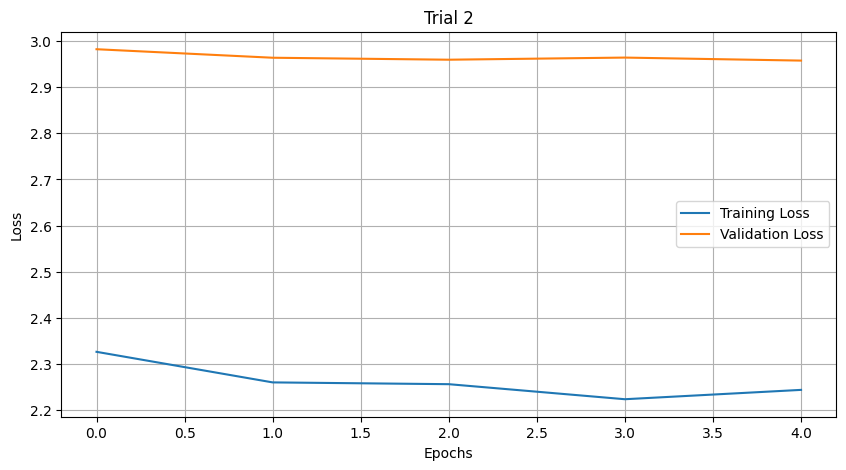

Trial 3/5
Batch size: 2, Learning rate: 1.0257672866554319e-07, Weight decay: 4.784444450956468e-05
Epoch 1, Train Loss: 2.253583861332314
Epoch 1, Validation Loss: 2.960110528128488
Epoch 2, Train Loss: 2.2486958153107586
Epoch 2, Validation Loss: 2.960393786430359
Epoch 3, Train Loss: 2.2451766846226713
Epoch 3, Validation Loss: 2.9609173110553195
Epoch 4, Train Loss: 2.2128676713681688
Epoch 4, Validation Loss: 2.9612729293959483
Epoch 5, Train Loss: 2.245365806654388
Epoch 5, Validation Loss: 2.9616343719618663
Test Loss: 2.970324900415209


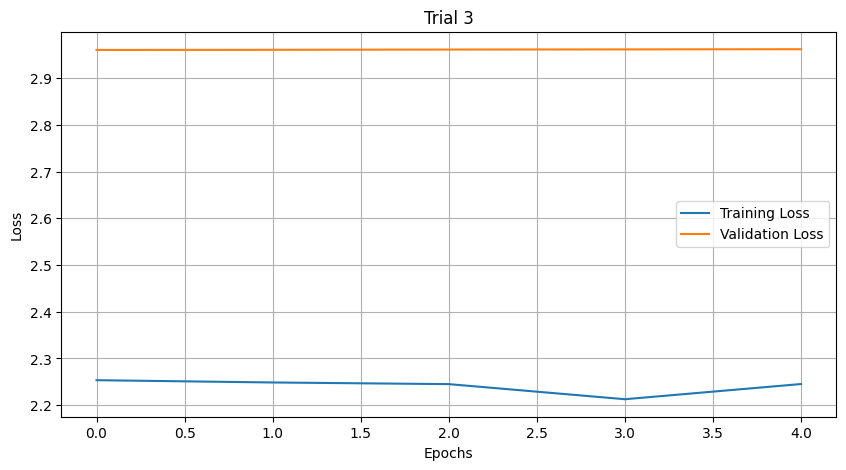

Trial 4/5
Batch size: 6, Learning rate: 9.89527903459092e-05, Weight decay: 1.7880432602929317e-05
Epoch 1, Train Loss: 2.568017945570104
Epoch 1, Validation Loss: 2.7639406323432922
Epoch 2, Train Loss: 2.2515773703070248
Epoch 2, Validation Loss: 2.953266441822052
Epoch 3, Train Loss: 2.1994385999791763
Epoch 3, Validation Loss: 2.878644108772278
Epoch 4, Train Loss: 2.191042900085449
Epoch 4, Validation Loss: 2.9802449345588684
Epoch 5, Train Loss: 2.1328201714683983
Epoch 5, Validation Loss: 2.968851625919342
Test Loss: 3.151836117108663


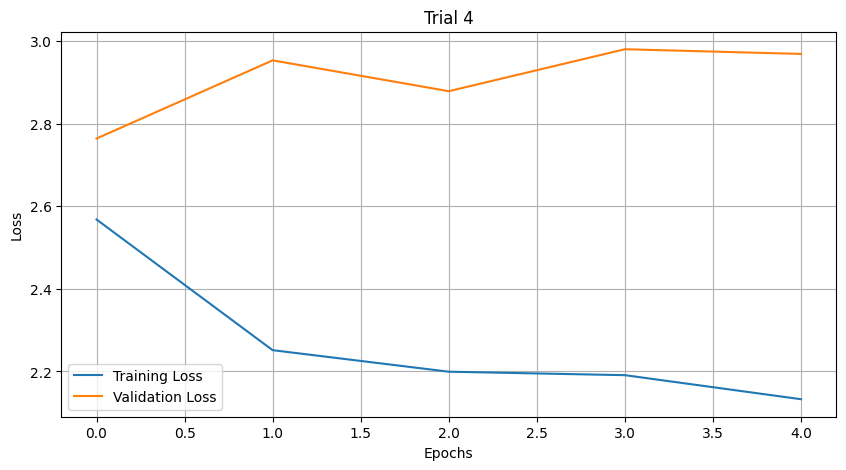

Trial 5/5
Batch size: 5, Learning rate: 5.165354852383129e-05, Weight decay: 2.6834119745348383e-05
Epoch 1, Train Loss: 2.218594580888748
Epoch 1, Validation Loss: 2.868272590637207
Epoch 2, Train Loss: 2.1148750245571137
Epoch 2, Validation Loss: 3.018638181686401
Epoch 3, Train Loss: 2.070671570301056
Epoch 3, Validation Loss: 3.057084655761719
Epoch 4, Train Loss: 2.068025177717209
Epoch 4, Validation Loss: 3.1358322620391847
Epoch 5, Train Loss: 2.038476884365082
Epoch 5, Validation Loss: 3.11305193901062
Test Loss: 3.448806047439575


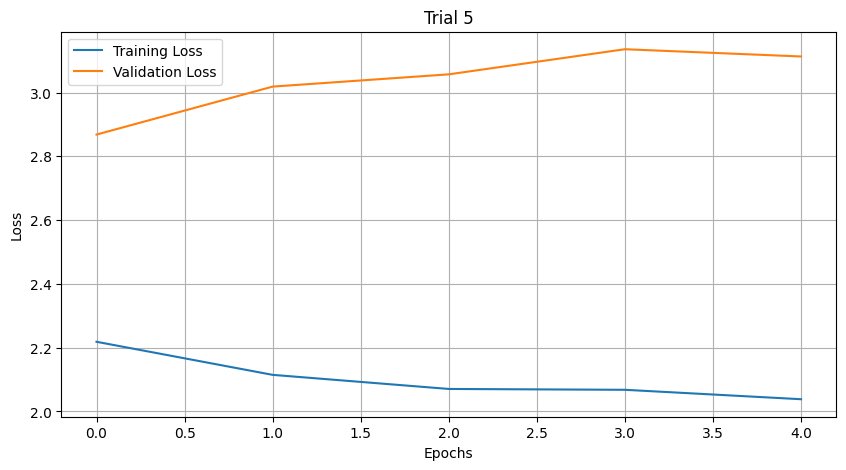

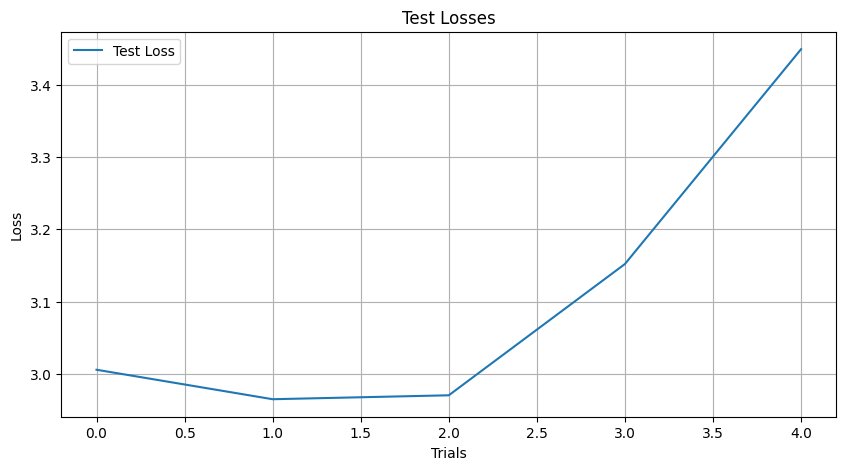

In [10]:
import random
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = get_resnet(config["resnet"], pretrained=False)
n_features = encoder.fc.in_features

# load pre-trained model from checkpoint
simclr_model = SimCLR(encoder=encoder, projection_dim=config["projection_dim"], n_features=n_features)
simclr_model.load_state_dict(torch.load(model_path, map_location=device))
simclr_model = simclr_model.to(device)

model = DetectionModel(simclr_model)
model = model.to(device)
model.train()

all_train_losses = []
all_val_losses = []
all_test_losses = []

for trial in range(config["trials"]):
    bs = random.randint(config["batch_size"][0], config["batch_size"][1])
    lr = 10 ** random.uniform(math.log10(config["lr"][0]), math.log10(config["lr"][1]))
    wd = 10 ** random.uniform(math.log10(config["weight_decay"][0]), math.log10(config["weight_decay"][1]))
    
    print(f"Trial {trial + 1}/{config['trials']}")
    print(f"Batch size: {bs}, Learning rate: {lr}, Weight decay: {wd}")

    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True, num_workers=config["workers"], collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, drop_last=True, num_workers=config["workers"], collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True, num_workers=config["workers"], collate_fn=collate_fn)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    train_losses = []
    val_losses = []

    for epoch in range(config["epochs"]):
        train_loss = 0
        for images, (class_labels, bbox) in train_dataloader:
            images = images.to(device)
            class_labels = class_labels.to(device)
            bbox = bbox.to(device)

            optimizer.zero_grad()
            predicted_classes, predicted_bboxes = model(images)
            loss = detection_loss(predicted_classes, predicted_bboxes, class_labels, bbox)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}')
        
        val_loss = validate_model(model, valid_dataloader, device)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')

    test_loss = validate_model(model, test_dataloader, device)
    all_test_losses.append(test_loss)
    print(f'Test Loss: {test_loss}')

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Trial {trial+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 5))
plt.plot(all_test_losses, label='Test Loss')
plt.xlabel('Trials')
plt.ylabel('Loss')
plt.title('Test Losses')
plt.legend()
plt.grid(True)
plt.show()
